# Convolutional Neural Network

In [ ]:
import pandas as pd
from finlab.data import Data
data = Data()
twii = data.get("發行量加權股價指數")
twii = twii['台股指數']
twii = twii.resample('15T').first().dropna()

## 製作features

In [21]:
import numpy as np
import tqdm
time_period = 200

cnn_x = []
cnn_y = []
indexs = []
for i in tqdm.tqdm_notebook(range(0, len(twii) - time_period - 1 - 11, 3)):
    s = twii.iloc[i:i+time_period].values
    cnn_x.append((s - s.min())/(s.max() - s.min()))
    r = twii.iloc[i+time_period+10] / twii.iloc[i+time_period-1]
    cnn_y.append(r)
    indexs.append(twii.index[i+time_period-1])

cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)




## Reshape features and labels

In [3]:
cnn_x = cnn_x.reshape(len(cnn_x), time_period, 1)
cnn_y = cnn_y.reshape(len(cnn_y), 1)

## Split traning and testing data

In [4]:
import datetime
cnn_x_train = cnn_x[indexes < datetime.datetime(2021,1,1)]
cnn_y_train = cnn_y[indexes < datetime.datetime(2021,1,1)]

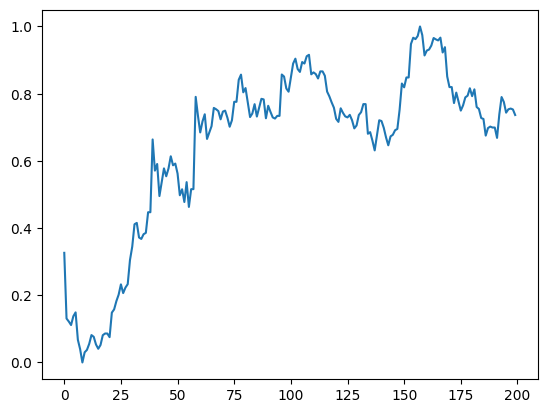

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cnn_x[0].reshape(1, len(cnn_x[0]))[0])


## CNN

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

input_shape = cnn_x[0].shape
time_period = 300
num_classes = 1

model = keras.Sequential()

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu', input_shape=cnn_x[0].shape))
model.add(layers.AveragePooling1D(5))

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu'))
model.add(layers.AveragePooling1D(5))
model.add(layers.Flatten())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.Dense(units=1, ))#activation = 'softmax'))

adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.01, amsgrad=False)

model.compile(loss='mse',
                optimizer=adam)

print(model.summary())

history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=200,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1, )


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 181, 20)           420       
_________________________________________________________________
average_pooling1d_2 (Average (None, 36, 20)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 17, 20)            8020      
_________________________________________________________________
average_pooling1d_3 (Average (None, 3, 20)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               7320      
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

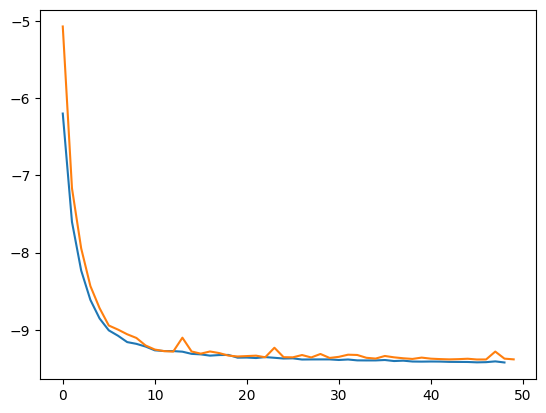

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log(history.history['loss'][1:]))
plt.plot(np.log(history.history['val_loss']))

In [17]:
ey = model.predict(cnn_x)
ey = pd.Series(ey.swapaxes(0, 1)[0], index=indexes)

<AxesSubplot:>

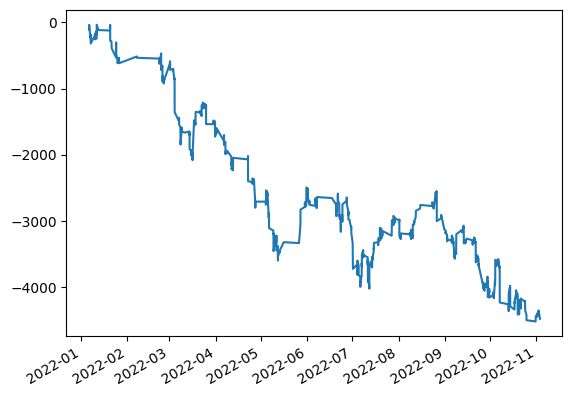

In [18]:

eq = twii[pd.to_datetime(indexes)]
gain = (eq.shift(-1) - eq)

signal = (ey > ey.quantile(0.9)).rolling(20).sum() > 0
eq = (gain[signal])['2022':].cumsum()
eq.plot()


eq = twii[pd.to_datetime(indexes)]
gain = (eq.shift(-1) - eq)

signal = (ey > ey.quantile(0.9)).rolling(20).sum() > 0
eq = (gain[signal])['2021':].cumsum()
eq.plot()

In [19]:
signal['2021':].astype(int).diff().abs().sum()

71.0

In [20]:
# validation loss 三個執行週期沒改善就停止訓練
my_callbacks = [
    model.keras.callbacks.EarlyStopping(patience=3, monitor = 'val_accuracy'),
]

# 訓練 20 次
history = model.fit(x_train_norm, y_train, epochs=20, validation_split=0.2, callbacks=my_callbacks)

AttributeError: 'Sequential' object has no attribute 'keras'

In [ ]:
checkpoint_filepath = '.\\tmp\\checkpoint'
model_checkpoint_callback = [model.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True)]


# 網路文章
https://easonc13.medium.com/如何使用-python-繪製圖型結構-graphviz-套件的使用筆記-抬升raise-5a56a401e67d

https://ithelp.ithome.com.tw/articles/10234389

https://waternotetw.blogspot.com/2020/07/

In [22]:
import tensorflow as tf


# 建立模型
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

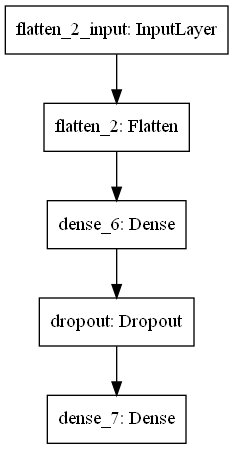

In [23]:
# 需安裝 graphviz (https://www.graphviz.org/download/)
# 將安裝路徑 C:\Program Files (x86)\Graphviz2.38\bin 新增至環境變數 path 中
#! pip install graphviz
#! pip install pydotplus
from graphviz import Digraph
tf.keras.utils.plot_model(model, to_file='model.png')

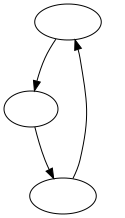

In [24]:
from graphviz import Digraph
dot = Digraph(comment='The Round Table')
names = ['剪刀', '石頭', '布']
for i in names:  #新增三個結點，分別叫做剪刀石頭布
    dot.node(i, i)
for i in range(len(names)): #將互相克制的關係畫上去
    dot.edge(names[i], names[i-1], "克制")
dot

In [25]:
#匯出成 pdf 檔案
dot.render('./round-table.gv', view=True)
#顯示 Graphviz 標記碼
str(dot)

'// The Round Table\ndigraph {\n\t"剪刀" [label="剪刀"]\n\t"石頭" [label="石頭"]\n\t"布" [label="布"]\n\t"剪刀" -> "布" [label="克制"]\n\t"石頭" -> "剪刀" [label="克制"]\n\t"布" -> "石頭" [label="克制"]\n}\n'